## London and Yerevan Image Classification

In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt 
import os

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
from shutil import copy
from PIL import Image
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F 
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score

## CREATING YEREVAN AND LONDON SEPARATE FILES

In [3]:
os.mkdir('./London/')
os.mkdir('./Yerevan/')

In [4]:
data_path = "./Vision/data/"

for l in os.listdir(data_path):
    if l == 'test':
        continue
    for img_file in os.listdir(data_path + l):
        try:
            r = Image.open(data_path+l + '/' + img_file)
            del r
        except:
            continue
        
        if "london" in data_path+l+img_file:
            copy(data_path + l + '/' + img_file, './London/')
        
        if "yerevan" in data_path+l+img_file:
            copy(data_path + l + '/' + img_file, './Yerevan/')

## Data Cleaning and resizing images

In [5]:
trans = transforms.Compose([transforms.Scale((100, 100)), 
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

C:\Users\Arman\AppData\Roaming\Python\Python37\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
for dir_ in ['./Yerevan/', './London/']:
    for file_name in os.listdir(dir_):
        if os.path.splitext(file_name)[1] != ".jpg":
            os.remove(dir_ + file_name)
            print('removed', dir_ + file_name)
            continue
        if 'ipynb_checkpoints' in file_name:
            continue
        x = Image.open(dir_+ file_name)
        if (np.array(x).shape[2] == 4):
            os.remove(dir_ + file_name)
            print('removed', dir_ + file_name)
            continue
        x = trans(x)
        
        

removed ./Yerevan/183_yerevan.jpeg
removed ./Yerevan/209_yerevan.jpeg
removed ./Yerevan/30_yerevan.jpeg
removed ./Yerevan/9_yerevan.12
removed ./London/142_london.$_
removed ./London/152_london.jpeg
removed ./London/158_london.-jpg
removed ./London/176_london.12
removed ./London/203_london.jpeg
removed ./London/235_london.jpeg
removed ./London/33_london.jpg
removed ./London/71_london.jpeg
removed ./London/76_london.jpeg
removed ./London/90_london.Be
removed ./London/99_london.jpeg


In [7]:
for test_file in os.listdir('./Vision/data/test'):
    try:
        r = Image.open(data_path+l + '/' + test_file)
        del r
    except:
        os.remove(data_path+l + '/' + test_file)

## Displaying random images

In [8]:
random_yerevan_img = plt.imread('./Yerevan/' + random.choice(os.listdir('./Yerevan')))
random_london_img = plt.imread('./London/' + random.choice(os.listdir('./London')))

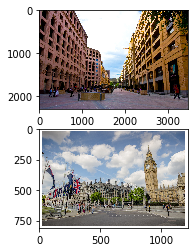

In [9]:
_, axarr = plt.subplots(2)
axarr[0].imshow(random_yerevan_img)
axarr[1].imshow(random_london_img)

## Creating the dataframe with columns file and target

In [10]:
import pandas as pd 

train_df = pd.DataFrame(columns = ['file', 'target'])
for dir_ in ['./Yerevan/', './London/']:
    for file_name in os.listdir(dir_):
        
        if not ('yerevan' in file_name or 'london' in file_name):
            continue
        
        train_df = train_df.append({'file' : dir_ + file_name, 'target' : 0 if 'london' in file_name else 1}, ignore_index=True)
        

In [11]:
test_df = pd.DataFrame(columns = ['file', 'target'])

for file_name in os.listdir('./Vision/data/test/'):
    test_df = test_df.append({'file' : './Vision/data/test/' + file_name, 'target' : 0 if 'london' in file_name else 1}, ignore_index=True)
        

In [14]:
train_df

file target
0    ./Yerevan/103_yerevan.jpg      1
1    ./Yerevan/106_yerevan.jpg      1
2    ./Yerevan/113_yerevan.jpg      1
3    ./Yerevan/114_yerevan.jpg      1
4    ./Yerevan/118_yerevan.jpg      1
..                         ...    ...
126     ./London/83_london.jpg      0
127     ./London/84_london.jpg      0
128     ./London/92_london.jpg      0
129     ./London/97_london.jpg      0
130     ./London/98_london.jpg      0

[131 rows x 2 columns]

In [12]:
test_df.head()

file target
0  ./Vision/data/test/236_yerevan.jpg      1
1  ./Vision/data/test/237_yerevan.jpg      1
2  ./Vision/data/test/238_yerevan.jpg      1
3   ./Vision/data/test/239_london.jpg      0
4  ./Vision/data/test/240_yerevan.jpg      1

## Pytorch Dataset and Dataloader

In [15]:
class MyDataset(Dataset):
    def __init__(self, df, mode, transform):
        super().__init__()
        self.df = df 
        self.mode = mode
        self.transform = transform
        self.len_ = len(self.df)
        
    def __len__(self):
        return self.len_
    
    @staticmethod
    def load_img(fname):
        img = Image.open(fname)
        return img

    def __getitem__(self, idx):
        x = MyDataset.load_img(self.df.loc[idx].file)
        x = self.transform(x)
        y = self.df.loc[idx].target
        
        return x, y

In [16]:
train_dataset = MyDataset(df=train_df, mode='train', transform=trans)
test_dataset = MyDataset(df=test_df, mode='test', transform=trans)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [18]:
for x, target in iter(train_loader):
    print(target)
    print(x.shape)
    break

tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1])
torch.Size([16, 3, 100, 100])


In [19]:
for x, target in iter(test_loader):
    print(x.shape)
    print(target)
    break

torch.Size([16, 3, 100, 100])
tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0])


## Define class for  fully connected NN

In [20]:
class SimpleDenseNet(nn.Module):
    def __init__(self):
       
        super(SimpleDenseNet, self).__init__()
        
        self.fc1 = nn.Linear(3*100*100, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(0.5)
        self.last_layer = nn.Linear(256, 2)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):

        x = x.view(x.shape[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.sigmoid(self.last_layer(x))
        
        return x

## Define class for Convolution Network

In [21]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5)
        
        self.fc1 = nn.Linear(50 * 44 * 44 , 512) 
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        x = x.view(-1, 50 * 44 * 44)  # !!! Аналог Flatten в keras
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [22]:
conv_net = SimpleConvNet()

In [23]:
net = SimpleDenseNet()

## Train and evaluate fully connected Neural Network

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [25]:
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    y_preds = []
    y_reals = []
    
    net.train()
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = net(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
            
    print('epoch', epoch)
    net.eval()
    print('Running Loss:', running_loss)
    
    for x_batch, y_batch in train_loader:

        y_pred = net(x_batch)
        _, predicted = torch.max(y_pred.data, 1)

        for p, y in zip(y_batch, predicted):
            y_preds.append(p)
            y_reals.append(y)

    print('Accuracy in train:', accuracy_score(y_preds, y_reals))

    y_preds = []
    y_reals = []


    for x_batch, y_batch in test_loader:

        y_pred = net(x_batch)
        _, predicted = torch.max(y_pred.data, 1)

        for p, y in zip(y_batch, predicted):
            y_preds.append(p)
            y_reals.append(y)

    print('Accuracy in test:', accuracy_score(y_preds, y_reals))
        

C:\Users\Arman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\Arman\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1358: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
..\torch\csrc\utils\python_arg_parser.cpp:698: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


epoch 0
Running Loss: 5.804921805858612
Accuracy in train: 0.7938931297709924
Accuracy in test: 0.6410256410256411
epoch 1
Running Loss: 4.9096976816654205
Accuracy in train: 0.9389312977099237
Accuracy in test: 0.9487179487179487
epoch 2
Running Loss: 3.8716426491737366
Accuracy in train: 0.9770992366412213
Accuracy in test: 0.9743589743589743
epoch 3
Running Loss: 3.3896787464618683
Accuracy in train: 0.9923664122137404
Accuracy in test: 0.9743589743589743
epoch 4
Running Loss: 3.096729129552841
Accuracy in train: 1.0
Accuracy in test: 0.9743589743589743



## Train and evaluate Convolution Neural Network

In [34]:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer_cnn = torch.optim.SGD(conv_net.parameters(), lr=learning_rate)

In [35]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score

for epoch in tqdm_notebook(range(2)):

    running_cnn_loss = 0.0
    y_cnn_preds = []
    y_cnn_reals = []
    
    conv_net.train()
    
    for x_batch, y_batch in train_loader:
        optimizer_cnn.zero_grad()
        y_cnn_pred = conv_net(x_batch)
        loss = loss_fn(y_cnn_pred, y_batch)
        loss.backward()
        optimizer_cnn.step()

        running_cnn_loss += loss.item()
            
    print('epoch', epoch)
    conv_net.eval()
    print('Running Loss:', running_cnn_loss)
    
    for x_batch, y_batch in train_loader:

        y_cnn_pred = conv_net(x_batch)
        _, cnn_predicted = torch.max(y_cnn_pred.data, 1)

        for p, y in zip(y_batch, cnn_predicted):
            y_cnn_preds.append(p)
            y_cnn_reals.append(y)

    print('Accuracy in train:', accuracy_score(y_cnn_preds, y_cnn_reals))

    y_cnn_preds = []
    y_cnn_reals = []


    for x_batch, y_batch in test_loader:

        y_cnn_pred = conv_net(x_batch)
        _, cnn_predicted = torch.max(y_cnn_pred.data, 1)

        for p, y in zip(y_batch, cnn_predicted):
            y_cnn_preds.append(p)
            y_cnn_reals.append(y)

    print('Accuracy in test:', accuracy_score(y_cnn_preds, y_cnn_reals))

C:\Users\Arman\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


epoch 0
Running Loss: 6.929195523262024
Accuracy in train: 0.6641221374045801
Accuracy in test: 0.5128205128205128
epoch 1
Running Loss: 3.1686078161001205
Accuracy in train: 0.9389312977099237
Accuracy in test: 0.9743589743589743



## Brief Summary

To begin my task I started importing all the modules and libraries that are needed. Later, my first task was to create two separate files London and Yerevan where in each file I will have my separate Yerevan images and London images. Here I just iterated over the Vision data folders and checked if london string contained in the file path and using shutil library's copy method copied all london images to London folder and wih same logic copied yerevan images to Yerevan folder.

Next task was to do data cleaning and see what images need to be extracted. I found out that one of the images in train data ,for example, had a different shape and so could not be transformed to 100x100 size as I did for all the images to hava faster training later. So I removed the image which had not 3 channels as all other images had and also I noticed that most of the images had jpg file extension which could have been easily opened(they were not corupted and could be opened with cv2 and Image) and some of the images had other file extension which I exctracted just checking the file extensins of all the images. Moreover in the test data there was a file that could not be opened so I found that image and removed it. I printed( for saving task ) all the removed images and with all this done I finished the data cleaning part.

Next I created 2 dataframes with columns of files and labels 0 and 1( for classification) which need to be used later for creating the dataset with the help of the pytorch dataloader, shuffling the data and transforming(resizing) them into 100x100 so as to have all images of same size and and reducing the size of images for faster training of Neural Nets later in the code. For creating the dataset I used the library pytorch with its appropriate features and methods and used the pytorch dataloader getting the desired train data and test data with the images resized and shuffled.

Next, having the train and test dataset I continued the task by creating the dense 3 layer neural network architecture which was mentioned in the task. Here I simply used 256 neurons in each layers fully connected with its output layers using relu activation function for non_linearity, using 50 percent dropout regularization technique and for output layer using sigmoid activation function as I had a binary classification task.   

Next I created the Convolution architecture which was mentioned in the optional task defining a CNN network with 2 convolution layers with max pooling ( with stride two and kernel size 2) after each convolution layer( conv layer and max pooling for reducing number of parameters and dimensionality reduction). Here I also used relu activation function since the relu is mostly used when dealing with the images. I used kernel size 5 with 20 feature map kernels in the first conv and 50 in the second which are an example of parameters that could be tuned during the training. And after conv layers I used 2 dense fully connected layers instead of 3 as in simple 3 layer neural network mentioned in the previous paragraph. 

The only part that was left was to train the simple dense 3 layer Neural Net and Convolution Net on our dataset and compare the results. In simple neural net after tuning the parameters and using Adam optimizer with learning rate 0.0001 and defining lose to be the cross entropy loss I got very good results in both the training and the testing set and for the evaluation for the test set I got 97 percent accuracy. After I started to train my Convolution Neural network,I had the problem of stucking in the local minimum of the loss function and after tuning the parameters using sgd optimizer , defining bigger learning rate than in simple neural net and using again crossentropy loss I got again around 97 percent accuracy on the test set so both simple neural net and Cnn performed really well on our dataset.

To summarize the main problem of the dataset was that data could have been not enough to train neural nets and get good results because as a matter of fact neural nets usually require big data to be trained and give good results. But as I could conclude and just manually look at the pics I could see that the yerevan and london images were mainly easily recognizable and the difference was mainly very obvious. For example, for yerevan images there were many pics of Cascade , Masis Mountain and Republic Square which really differed from the pics of london so even though the dataset was small the neural network could easily find out the two yerevan and london image clusters and give very good results on the test set with just training Fn and CNN with couple of epochs. Both running SImple 3 layer Dense Net and CNN with 2 conv layers, max pooling and fully connected layers with couple of epochs were enough to get a really good accuracy score. 